In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
connection = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Display the columns for Measurement table.

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Display the columns for station table.

inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


<Figure size 720x720 with 0 Axes>

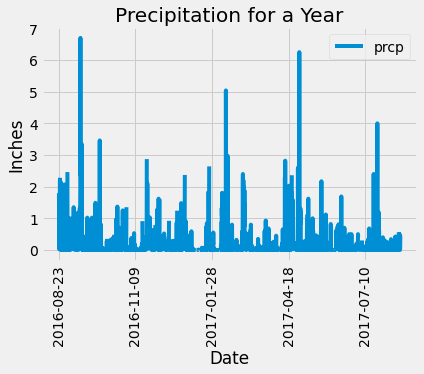

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

start_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
start_date

# # Calculate the date 1 year ago from the last data point in the database

year_ago = (dt.datetime.strptime(start_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
year_ago

# # Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago ).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column

prec_df = pd.DataFrame(precipitation_data)
prec_df.set_index('date',inplace=True)
prec_df

# # Sort the dataframe by date

prec_df_sorted = prec_df.sort_values("date")
prec_df_sorted

# # Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize = (10,10))
prec_df_sorted.plot()
plt.title("Precipitation for a Year")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation = 'vertical')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
total_station = session.query(Station.station).count()
print(f"There are total {total_station} stations.")


There are total 9 stations.


In [16]:
# What are the most active stations?
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).first()


print(f"Most active station is {active_station[0]}")

Most active station is USC00519281


In [17]:
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station))\
             .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
      
for station in active_station:
    print(station)



('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = active_station[0][0]

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),
                      func.avg(Measurement.tobs)).filter(Measurement.station == top_station)
                      
stats_list=list(stats)

print(f"Lowest temperature recorderd is {stats_list[0][0]}")
print(f"Highest temperature recorderd is {stats_list[0][1]}")
print(f"Average temperature recorderd is {'{0:.2f}'.format(stats_list[0][2])}")


Lowest temperature recorderd is 54.0
Highest temperature recorderd is 85.0
Average temperature recorderd is 71.66


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(Measurement.station,Measurement.tobs).\
              filter(Measurement.station==top_station).\
                                filter(Measurement.date >= year_ago).\
                                order_by(Measurement.date.desc()).all()
station_temp_df = pd.DataFrame(station_temp)
station_temp_df.head(10)

,station,tobs
0,USC00519281,79.0
1,USC00519281,76.0
2,USC00519281,76.0
3,USC00519281,77.0
4,USC00519281,77.0
5,USC00519281,77.0
6,USC00519281,83.0
7,USC00519281,82.0
8,USC00519281,77.0
9,USC00519281,76.0


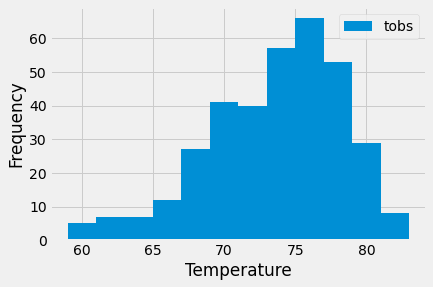

In [20]:
# plot the above results as a histogram.

x = station_temp_df["tobs"]

plt.hist(x, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_stat = calc_temps('2016-08-23','2017-08-23')
trip_stat

[(58.0, 74.59058295964125, 87.0)]

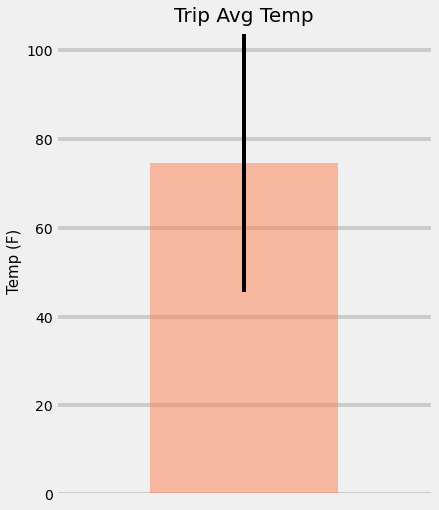

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_stat_df = pd.DataFrame(trip_stat, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_stat_df['Avg Temp']

tmin_tmax_temp = trip_stat_df.iloc[0]['Max Temp'] - trip_stat_df.iloc[0]['Min Temp']


avg_temp.plot(kind='bar', yerr=tmin_tmax_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)", fontsize=15)
plt.xticks([])
plt.ylim((0,105))
plt.grid( linestyle='-', linewidth=4)
plt.show()



In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
